<div style="text-align: center; font-size: 16px;">
    <strong>Course:</strong> Machine Learning Operations |
    <strong>Lecturer:</strong> Prof. Dr. Klotz |
    <strong>Date:</strong> 17.05.2025 |
    <strong>Name:</strong> Sofie Pischl
</div>

# <center>Prediction</center>

# Vorhersage von Themen-Trends in Social Media
Dieses Notebook baut auf der bisherigen Datenexploration auf und verfolgt das Ziel, verschiedene **Predictive Analysen** durchzuführen. Im Fokus stehen dabei:

- Die **Vorhersage von Topic-Zugehörigkeit** basierend auf Text
- Die **zeitliche Modellierung von Topics** zur Erkennung von Trends
- Die Untersuchung des Zusammenhangs zwischen **Sentiment** und Topic-Popularität

Die Analysen basieren auf den kombinierten Daten aus Reddit, YouTube und TikTok.

## 1. Daten laden und vorbereiten
Wir laden die vorbereiteten Daten (`df_clean.csv`), die bereits Topics, Zeitstempel und Sentiment enthalten. Die Daten müssen so strukturiert sein, dass wir Topic-Häufigkeiten pro Zeitfenster analysieren können.

In [1]:
from pathlib import Path
import pandas as pd


BASE_DIR = Path().resolve().parent
RAW_DIR = (BASE_DIR / "./data/processed").resolve()

# Datei laden
df = pd.read_csv(RAW_DIR / "social_media_data_with_topics.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
df['date'] = df['timestamp'].dt.date  # Tagesgenauigkeit

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\SofiePischl\\Documents\\01_HdM\\10_ML_OPS\\TrendAnalyseSocialMedia\\data\\processed\\social_media_data_with_topics.csv'

## 2. Vorhersage der Topic-Zugehörigkeit basierend auf Text
Hier trainieren wir ein Klassifikationsmodell, das aus einem Text vorhersagt, welchem Topic dieser am wahrscheinlichsten zugeordnet wird.
Dies erlaubt die automatische Kategorisierung neuer Texte.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Features und Ziel
X_text = df['text_clean'].astype(str)
y_topic = df['topic']

# TF-IDF-Vektorisierung
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(X_text)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y_topic, test_size=0.2, stratify=y_topic, random_state=42)

# Klassifikationsmodell
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.41      0.94      0.57        67
           0       0.00      0.00      0.00         8
           1       0.61      0.26      0.36        43
           2       0.00      0.00      0.00         3
           3       0.67      0.12      0.20        17
           4       1.00      0.22      0.36         9
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         4
          14       1.00      0.50      0.67         2
          15       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         2
          18       0.00    

c:\Users\SofiePischl\Documents\01_HdM\10_ML_OPS\TrendAnalyseSocialMedia\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SofiePischl\Documents\01_HdM\10_ML_OPS\TrendAnalyseSocialMedia\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SofiePischl\Documents\01_HdM\10_ML_OPS\TrendAnalyseSocialMedia\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

## 3. Zeitliche Modellierung der Topic-Häufigkeit
Wir verwenden **Facebook Prophet**, um die Entwicklung einzelner Topics über die Zeit zu modellieren und Trends zu extrapolieren.
Hierzu analysieren wir die Häufigkeit eines Topics pro Tag.

c:\Users\SofiePischl\Documents\01_HdM\10_ML_OPS\TrendAnalyseSocialMedia\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing


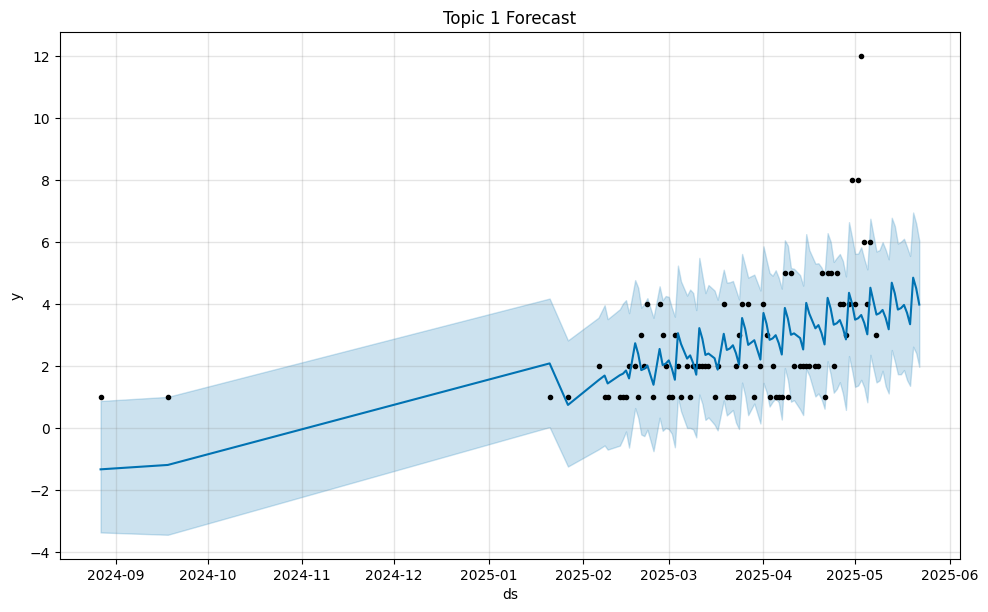

In [ ]:


from prophet import Prophet
import matplotlib.pyplot as plt

# Beispiel: Topic 1 analysieren
topic_id = 1
df_topic = df[df['topic'] == topic_id].groupby('date').size().reset_index(name='count')
df_topic.columns = ['ds', 'y']

# Prophet-Modell
model = Prophet()
model.fit(df_topic)
future = model.make_future_dataframe(periods=14)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.title(f'Topic {topic_id} Forecast')
plt.show()

## 4. Analyse: Sentiment vs. Topic-Popularität
Hier untersuchen wir, ob sich die durchschnittliche Stimmung innerhalb eines Topics über die Zeit verändert – und ob sich dies auf die Verbreitung des Themas auswirkt.

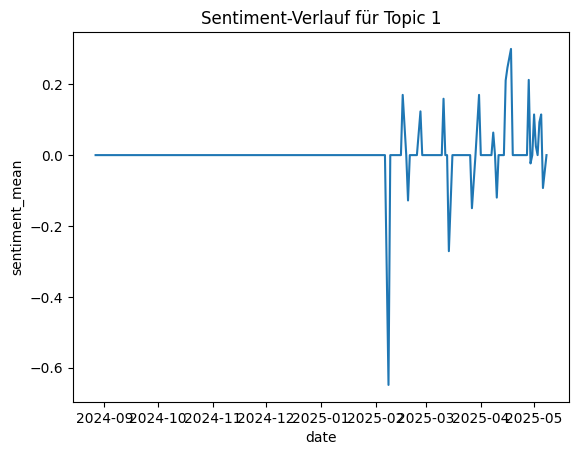

In [ ]:
import seaborn as sns

# Mittleres Sentiment und Topic-Frequenz pro Tag
df_sentiment = df.groupby(['date', 'topic']).agg(
    topic_count=('topic', 'count'),
    sentiment_mean=('vader_score', 'mean')  # ggf. 'roberta_sentiment' oder 'sentiment_polarity'
).reset_index()

# Beispiel-Plot für Topic 1
sns.lineplot(data=df_sentiment[df_sentiment['topic'] == 1], x='date', y='sentiment_mean')
plt.title('Sentiment-Verlauf für Topic 1')
plt.show()